# Model Analysis and Intro to more complex CNN Models

## Importing Data

Remember that the information was already saved from the 'test_adael' file? Well, we just need to import it.

In [8]:
#Lets import all packages again just that we have everything we need

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # important to avoir an error (the truncated picture error)
from sklearn.model_selection import train_test_split
import seaborn as sns

In [9]:
_X = []
_y = []

idx = 0
for genus in os.listdir("raw_data/Mushrooms"):
    for image in os.listdir(f"raw_data/Mushrooms/{genus}"):
        temp_img = plt.imread( os.path.join("raw_data/Mushrooms", genus, image))
        if len(temp_img.shape) < 3 : # necessary because there is an image that has no RGB dimension (wtf ??)
                continue
        trans_img = cv2.resize(temp_img, (100, 100), interpolation = cv2.INTER_AREA) # normlizing the pixels of images
        _X.append(trans_img)
        _y.append(genus)
        idx += 1

X = np.concatenate(_X , axis = 0).reshape((idx, 100,100,3)) # putting an image as one item in the tensor
y = np.array(_y)

### Now We can start with some data analysis and visualization

In [10]:
y = np.array(y)
labels= np.unique(y)
labels

array(['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma',
       'Hygrocybe', 'Lactarius', 'Russula', 'Suillus'], dtype='<U11')

In [11]:
#Plot a count graphs
import pandas as pd
y = np.array(y)
y_Series = pd.Series(y)
values = y_Series.value_counts()


/var/folders/w1/b1w4nxzd69q4q3mzdg9170wm0000gn/T/ipykernel_10599/529735857.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


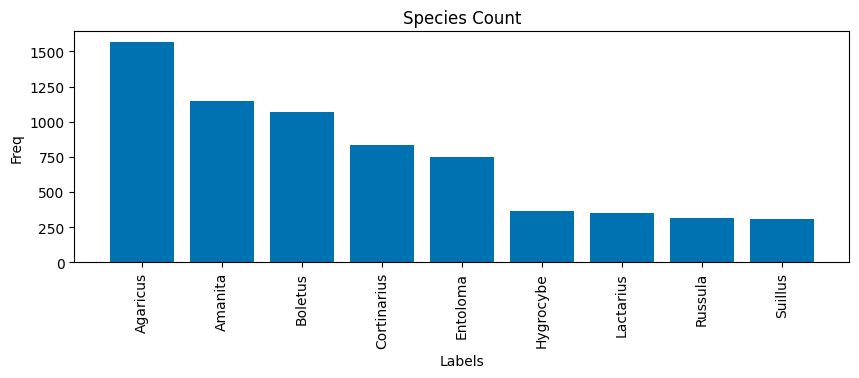

In [12]:
form = {'family': 'serif', 'color': 'blue', 'size': 25} 

width = np.min([len(labels), 20])
plt.figure(figsize=(10,3))
plt.style.use('seaborn-colorblind')
plt.bar(labels, values)
plt.title ('Species Count')
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Labels')
plt.ylabel('Freq')
plt.show()

### Triming the Training dataset is important. The number of difference between species will imbalance the model.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [14]:
y_train_series = pd.Series(y_train).value_counts()

/var/folders/w1/b1w4nxzd69q4q3mzdg9170wm0000gn/T/ipykernel_10599/3479052363.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


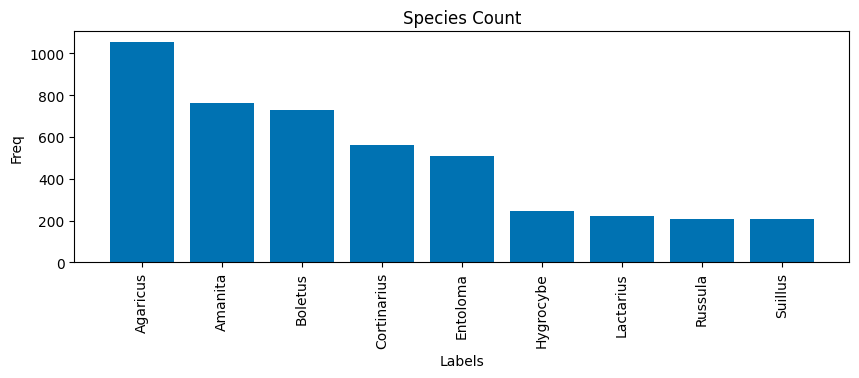

In [15]:
form = {'family': 'serif', 'color': 'red', 'size': 25} 

width = np.min([len(labels), 20])
plt.figure(figsize=(10,3))
plt.style.use('seaborn-colorblind')
plt.bar(labels, y_train_series)
plt.title ('Species Count')
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Labels')
plt.ylabel('Freq')
plt.show()

In [16]:
def trim (df, max_samples, min_samples, column): 
    df = df.copy()
    classses = df[column].unique()
    class_count = len(classses)
    length = len(df)
    print( 'dataframe initially is of length ',length, ' with ', class_count, ' classes')
    
    groups = df.groupby(column)
    trimmed_df = pd.DataFrame(columns=df.columns)
    groups = df.groupby(column)
    
    for label in df[column].unique():
        group = groups.get_groups(label)
        count = len(group)
        
        if count > max_samples:
            sampled_group = group.sample(n=max_samples, random_state =1, axis=0)
            trimmed_df = pd.concat([trimmed_df,sampled_group], axis= 0)
            
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    
    
    classes = trimmed_df[column].unique()
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    
    
    return trimmed_df, classes, class_count




In [17]:
min_samples = 240
max_samples = 240
column = 'labels'


## Setting The project above aside for a moment... We will focus on improving the model with various tips and tricks

### First we will make a more advanced 'Baseline' Model

In [29]:
### Adding a gentle dropout regularization to the model to start twitching model layers and see how to react
### If the model reacts to the dropout then we will procede to vary that



from tensorflow.keras import models,layers, optimizers


def initialize_model():

    model = models.Sequential()

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(32,(3,3), activation='relu',padding='same',input_shape=(100,100,3)))
    model.add(layers.Conv2D(32,(3,3), activation='relu',padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.2))
    
    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.2))
    
    ### Third Convolution & MaxPooling
    model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    
    model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.2))
    
    #Flattening the model
    model.add(layers.Flatten())
    
    #One more dropout layer with the respective dense layer to combine everything
    
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    
    ### Last layer - Classification Layer with 9 outputs corresponding to 9 mushrooms labels
    model.add(layers.Dense(9,activation='softmax'))
    
    ### Model compilation
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    
    return model
    

In [30]:
## Plotting diagnostic Learning curve rates
import matplotlib.pyplot as plt
import sys

def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	plt.savefig(filename + '_plot.png')
	plt.close()

In [34]:
## running hardness testing
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

def run_test_harness():
	# load dataset
    X = np.load("processed/X.npy")
    y = np.load("processed/y.npy")
	# prepare pixel data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
	# define model
    model = initialize_model()
    #initialize an earlystopping
    es = EarlyStopping(patience=3)
	# fit model
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), validation_split=0.2, callbacks=[es])
	# evaluate model
    _, acc = model.evaluate(X_test, y_test, verbose=1)
    print('> %.3f' % (acc * 100.0))
	# learning curves
    summarize_diagnostics(history)

In [35]:
run_test_harness()

Epoch 1/10


2022-11-30 11:25:35.809663: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


84/84 [==============================] - 20s 236ms/step - loss: 2.0532 - accuracy: 0.2114 - val_loss: 2.0490 - val_accuracy: 0.2189
Epoch 2/10
84/84 [==============================] - 19s 227ms/step - loss: 1.9917 - accuracy: 0.2505 - val_loss: 2.0419 - val_accuracy: 0.2628
Epoch 3/10
84/84 [==============================] - 19s 225ms/step - loss: 1.9303 - accuracy: 0.2837 - val_loss: 1.9216 - val_accuracy: 0.3001
Epoch 4/10
84/84 [==============================] - 19s 223ms/step - loss: 1.8679 - accuracy: 0.3155 - val_loss: 1.8850 - val_accuracy: 0.3313
Epoch 5/10
84/84 [==============================] - 19s 225ms/step - loss: 1.7801 - accuracy: 0.3639 - val_loss: 1.8435 - val_accuracy: 0.3440
Epoch 6/10
84/84 [==============================] - 19s 224ms/step - loss: 1.7361 - accuracy: 0.3841 - val_loss: 1.8151 - val_accuracy: 0.3738
Epoch 7/10
84/84 [==============================] - 19s 224ms/step - loss: 1.6668 - accuracy: 0.4027 - val_loss: 1.8083 - val_accuracy: 0.3716
Epoch 8/10

Model accuracy = 48% | model val accuracy = 40%
We can start to see some progress. For sure the model **dropout** came in handy. We will now add rotation to the images.

### Putting Data Augmentation and Rotation into play

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#create a data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, zoom_range=(0.5,0.8),rotation_range=10)
#prepare iterator
it_train = datagen.flow(X_train,y_train,batch_size=64)

steps = int(X_test.shape[0] / 64)

NameError: name 'model' is not defined

In [39]:
def initialize_model():

    model = models.Sequential()

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(32,(3,3), activation='relu',padding='same',input_shape=(100,100,3)))
    model.add(layers.Conv2D(32,(3,3), activation='relu',padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    
    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    
    ### Third Convolution & MaxPooling
    model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    
    model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    
    #Flattening the model
    model.add(layers.Flatten())
    
    #One more dropout layer with the respective dense layer to combine everything
    
    model.add(layers.Dense(64, activation='relu'))

    
    
    ### Last layer - Classification Layer with 9 outputs corresponding to 9 mushrooms labels
    model.add(layers.Dense(9,activation='softmax'))
    
    ### Model compilation
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    
    return model
    

In [44]:
def run_test_harness():
	# load dataset
    X = np.load("processed/X.npy")
    y = np.load("processed/y.npy")
	# prepare pixel data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
	# define model
    model = initialize_model()
    #initialize an earlystopping
    es = EarlyStopping(patience=3)
	# fit model
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, zoom_range=(0.5,0.8),rotation_range=10)
    it_train = datagen.flow(X_train,y_train,batch_size=64)
    steps = int(X_test.shape[0] / 64)
    history = model.fit_generator(it_train,steps_per_epoch= steps, epochs=15,validation_data=(X_test, y_test), verbose=1)
	# evaluate model
    _, acc = model.evaluate(X_test, y_test, verbose=1)
    print('> %.3f' % (acc * 100.0))
	# learning curves
    summarize_diagnostics(history)

In [45]:
run_test_harness()

/var/folders/w1/b1w4nxzd69q4q3mzdg9170wm0000gn/T/ipykernel_10599/2229408155.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(it_train,steps_per_epoch= steps, epochs=15,validation_data=(X_test, y_test), verbose=1)


Epoch 1/15
31/31 [==============================] - 9s 276ms/step - loss: 2.0633 - accuracy: 0.2308 - val_loss: 2.0488 - val_accuracy: 0.2309
Epoch 2/15
31/31 [==============================] - 8s 264ms/step - loss: 2.0313 - accuracy: 0.2354 - val_loss: 2.0444 - val_accuracy: 0.2309
Epoch 3/15
31/31 [==============================] - 8s 261ms/step - loss: 2.0348 - accuracy: 0.2323 - val_loss: 2.0266 - val_accuracy: 0.2309
Epoch 4/15
31/31 [==============================] - 8s 261ms/step - loss: 2.0112 - accuracy: 0.2312 - val_loss: 1.9968 - val_accuracy: 0.2378
Epoch 5/15
31/31 [==============================] - 8s 267ms/step - loss: 1.9830 - accuracy: 0.2455 - val_loss: 1.9819 - val_accuracy: 0.2557
Epoch 6/15
31/31 [==============================] - 8s 261ms/step - loss: 1.9439 - accuracy: 0.2580 - val_loss: 1.9597 - val_accuracy: 0.2502
Epoch 7/15
31/31 [==============================] - 8s 267ms/step - loss: 1.8856 - accuracy: 0.3044 - val_loss: 1.8709 - val_accuracy: 0.2964
Epoch 

### Try combining both models and running through 20 epochs 
#### There will be data augmentation and data regularization
#### We will also maybe try to put l2 function into play


In [54]:
#Model initialization
from tensorflow.keras.optimizers import SGD

def initialize_model():

    model = models.Sequential()

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(32,(3,3), activation='relu',padding='same',input_shape=(100,100,3)))
    model.add(layers.Conv2D(32,(3,3), activation='relu',padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.2))
    
    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.2))
    
    ### Third Convolution & MaxPooling
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.2))
    
    
    #Flattening the model
    model.add(layers.Flatten())
    
    #One more dropout layer with the respective dense layer to combine everything
    
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    
    ### Last layer - Classification Layer with 9 outputs corresponding to 9 mushrooms labels
    model.add(layers.Dense(9,activation='softmax'))
    
    ### Model compilation
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    
    return model
    

In [56]:
## running hardness testing
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

def run_test_harness():
	# load dataset
    X = np.load("processed/X.npy")
    y = np.load("processed/y.npy")
	# prepare pixel data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
	# define model
    model = initialize_model()
    #initialize an earlystopping
    es = EarlyStopping(patience=3)
	# fit model
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), validation_split=0.2, callbacks=[es])
	# evaluate model
    _, acc = model.evaluate(X_test, y_test, verbose=1)
    print('> %.3f' % (acc * 100.0))
	# learning curves
    summarize_diagnostics(history)

In [53]:
run_test_harness()

Epoch 1/10
84/84 [==============================] - 34s 399ms/step - loss: 2.0802 - accuracy: 0.2015 - val_loss: 2.0975 - val_accuracy: 0.2167
Epoch 2/10
84/84 [==============================] - 33s 388ms/step - loss: 2.0207 - accuracy: 0.2375 - val_loss: 1.9799 - val_accuracy: 0.2413
Epoch 3/10
84/84 [==============================] - 33s 389ms/step - loss: 1.9696 - accuracy: 0.2680 - val_loss: 1.9517 - val_accuracy: 0.2614
Epoch 4/10
84/84 [==============================] - 33s 388ms/step - loss: 1.9338 - accuracy: 0.2879 - val_loss: 1.8954 - val_accuracy: 0.3045
Epoch 5/10
84/84 [==============================] - 33s 388ms/step - loss: 1.8816 - accuracy: 0.3017 - val_loss: 1.8218 - val_accuracy: 0.3299
Epoch 6/10
84/84 [==============================] - 33s 390ms/step - loss: 1.8429 - accuracy: 0.3306 - val_loss: 1.8247 - val_accuracy: 0.3552
Epoch 7/10
84/84 [==============================] - 33s 391ms/step - loss: 1.7713 - accuracy: 0.3587 - val_loss: 1.8233 - val_accuracy: 0.3537

#### Here we will use our best test score and print the Data Augmentation

In [59]:
def run_test_harness():
	# load dataset
    X = np.load("processed/X.npy")
    y = np.load("processed/y.npy")
	# prepare pixel data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
	# define model
    model = initialize_model()
    #initialize an earlystopping
    es = EarlyStopping(patience=15)
	# fit model
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, zoom_range=(0.5,0.8),rotation_range=10)
    it_train = datagen.flow(X_train,y_train,batch_size=64)
    steps = int(X_test.shape[0] / 64)
    history = model.fit_generator(it_train,steps_per_epoch= steps, epochs=100,validation_data=(X_test, y_test), verbose=1)
	# evaluate model
    _, acc = model.evaluate(X_test, y_test, verbose=1)
    print('> %.3f' % (acc * 100.0))
	# learning curves
    summarize_diagnostics(history)

In [60]:
run_test_harness()

Epoch 1/100


/var/folders/w1/b1w4nxzd69q4q3mzdg9170wm0000gn/T/ipykernel_10599/3003094861.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(it_train,steps_per_epoch= steps, epochs=100,validation_data=(X_test, y_test), verbose=1)


31/31 [==============================] - 16s 479ms/step - loss: 2.0962 - accuracy: 0.1941 - val_loss: 2.0686 - val_accuracy: 0.2309
Epoch 2/100
31/31 [==============================] - 15s 479ms/step - loss: 2.0748 - accuracy: 0.2102 - val_loss: 2.0660 - val_accuracy: 0.2309
Epoch 3/100
31/31 [==============================] - 14s 465ms/step - loss: 2.0672 - accuracy: 0.2081 - val_loss: 2.0421 - val_accuracy: 0.2309
Epoch 4/100
31/31 [==============================] - 15s 474ms/step - loss: 2.0348 - accuracy: 0.2273 - val_loss: 2.0534 - val_accuracy: 0.2354
Epoch 5/100
31/31 [==============================] - 14s 465ms/step - loss: 2.0343 - accuracy: 0.2240 - val_loss: 2.0322 - val_accuracy: 0.2279
Epoch 6/100
31/31 [==============================] - 15s 485ms/step - loss: 2.0303 - accuracy: 0.2293 - val_loss: 2.0272 - val_accuracy: 0.2339
Epoch 7/100
31/31 [==============================] - 15s 475ms/step - loss: 2.0078 - accuracy: 0.2500 - val_loss: 2.0068 - val_accuracy: 0.2373
Epoc

KeyboardInterrupt: 